# Imports

In [8]:
import os
import glob
import glob
import pickle
import random
import time
import logging
import statistics
import json
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Input, Reshape, UpSampling2D, MaxPooling2D, add
from tensorflow.keras.layers import SeparableConv2D, Conv2DTranspose, DepthwiseConv2D, Dense, Conv2D
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow import device

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import class_weight

from scipy.spatial.distance import euclidean

from PIL import Image
from PIL import ImageFile

# Model class

In [33]:
class cbir_cnn():

    def __init__(self):
        # Enviroment paths
        self.IMAGES_PATH = ''
        self.PLOTS_PATH = ''
        
        # Dataset
        self.X = None
        self.X_seg = None
        self.y = None
        self.sub_id = None
        self.tumour_area= None
        
        # Models
        self.encoder = None
        self.autoencoder = None
        self.classifier = None
        self.composed_model = None
    
    #### LOAD BRATS DATA FROM ####
    
    def load_data(self):
        X_train_load = []
        X_seg_load = []
        y_train_load = []
        sub_id_train_load = []
        tumour_area = []

        for i, folder_path in enumerate(glob.glob(self.IMAGES_PATH + '/*')):
            if i%75==0:
                print(str(i) + ' folders loaded')

            id = folder_path[-3:]

            for img_path in glob.glob(folder_path + '/*flair*.png'):
                img = Image.open(img_path)
                img_array = np.array(img)
                img_array = np.expand_dims(img_array, axis=0)
                
                img_array = np.append(img_array, [np.array(Image.open(img_path[:74] + 't1' + img_path[-8:]))], axis=0)
                img_array = np.append(img_array, [np.array(Image.open(img_path[:74] + 't1ce' + img_path[-8:]))], axis=0)
                img_array = np.append(img_array, [np.array(Image.open(img_path[:74] + 't2' + img_path[-8:]))], axis=0)
                
                img_array = np.rollaxis(img_array, 0, 3)
                X_train_load.append(img_array)
                
                path = img_path[:74] + 'hemi' + img_path[-8:]
                if os.path.exists(path):
                    img = Image.open(path)
                    img_array = np.array(img)
                    X_seg_load.append(img_array)
                else:
                    X_seg_load.append(None)
                    
                y_path = img_path[:74] + 'seg' + img_path[-8:]
                img = Image.open(y_path)
                img_array = np.array(img)
                y_train_load.append(img_array)

                sub_id_train_load.append(id)
                tumour_area.append(self.get_tum_area(img_array))

        
        X_train_aux = np.asarray(X_train_load)
        X_train_aux = X_train_aux/127.5 - 1
        self.X = X_train_aux
        
        X_seg_load = np.asarray(X_seg_load)
        self.X_seg = X_seg_load
        
        y_train_aux = np.asarray(y_train_load)
        y_train_aux = y_train_aux/64
        self.y = y_train_aux
        
        self.sub_id = np.asarray(sub_id_train_load)
        self.tumour_area = np.asarray(tumour_area)
    
    def load_labels(self, y):
        labels = []
        for img in y:
            if np.amax(img) > 0:
                labels.append(1)
            else:
                labels.append(0)
                
        return np.asarray(labels)
    
    def get_tum_area(self, img_array):
        return np.count_nonzero(img_array > 0)
        
    #### RECOMMENDATION SYSTEM ####
    
    def get_nn(self, latent_representations, img_index):
        source_img = latent_representations[img_index]
        source_id = self.sub_id[img_index]

        X_neighbors = []
        X_seg_neighbors = []
        y_neighbors = []
        id_neighbors = []
        distances = []
        
        tum_pred = self.classifier.predict(np.expand_dims(self.X[img_index], axis=0))

        for i, candidate in enumerate(latent_representations):
            if self.sub_id[i] != source_id and self.sub_id[i] not in id_neighbors and self.tumour_area[i] != 0:
                if tum_pred>0.90:
                    if self.tumour_area[i] != 0:
                        distances.append(euclidean(source_img, candidate))

                        X_neighbors.append(self.X[i])
                        X_seg_neighbors.append(self.X_seg[i])
                        y_neighbors.append(self.y[i])
                        id_neighbors.append(self.sub_id[i])
                else:
                    distances.append(euclidean(source_img, candidate))

                    X_neighbors.append(self.X[i])
                    X_seg_neighbors.append(self.X_seg[i])
                    y_neighbors.append(self.y[i])
                    id_neighbors.append(self.sub_id[i])

        return distances, np.asarray(X_neighbors), np.asarray(X_seg_neighbors), np.asarray(y_neighbors), np.asarray(id_neighbors)
    
    def plot_nearest_neighbor(self, neighbors, source_X, source_X_seg, source_y, source_id, num_neighbors):
        f, ax = plt.subplots(3, num_neighbors + 1, figsize=(8*num_neighbors, 18))

        ax[0][0].set_title('Query image')
        ax[0][0].imshow(source_X[:,:,3], cmap='gray', vmin=0, vmax=1)
        ax[0][0].get_xaxis().set_visible(False)
        ax[0][0].get_yaxis().set_visible(False)
        
        if np.any(source_X_seg) != None:
            ax[1][0].set_title('Query image')
            ax[1][0].imshow(source_X_seg, cmap='magma', vmin=0, vmax=256)
            ax[1][0].get_xaxis().set_visible(False)
            ax[1][0].get_yaxis().set_visible(False)

        ax[2][0].set_title('Query image')
        ax[2][0].imshow(source_y, cmap='magma', vmin=0, vmax=4)
        ax[2][0].get_xaxis().set_visible(False)
        ax[2][0].get_yaxis().set_visible(False)
        
        for i in range(num_neighbors):
            ax[0][i+1].imshow(neighbors[i][1][:,:,3], cmap='gray', vmin=0, vmax=1)
            ax[0][i+1].get_xaxis().set_visible(False)
            ax[0][i+1].get_yaxis().set_visible(False)

            if np.any(neighbors[i][2]) != None:
                ax[1][i+1].imshow(neighbors[i][2], cmap='magma', vmin=0, vmax=256)
                ax[1][i+1].get_xaxis().set_visible(False)
                ax[1][i+1].get_yaxis().set_visible(False)
            
            ax[2][i+1].imshow(neighbors[i][3], cmap='magma', vmin=0, vmax=4)
            ax[2][i+1].get_xaxis().set_visible(False)
            ax[2][i+1].get_yaxis().set_visible(False)

        plt.show()
    
    def recom_system(self, X_low, img_idx, n_neighbors):
        distances, X_neighbors, X_seg_neighbors, y_neighbors, id_neighbors = self.get_nn(X_low, img_index=img_idx)
        neighbors = zip(distances, X_neighbors, X_seg_neighbors, y_neighbors, id_neighbors)
        neighbors = sorted(neighbors, key=lambda x: x[0])
        neighbors = list(neighbors)
        
        self.plot_nearest_neighbor(neighbors,
                                   self.X[img_idx], self.X_seg[img_idx], self.y[img_idx], self.sub_id[img_idx],
                                   num_neighbors=n_neighbors)
    
    #### DICE COEFFICIENT ####
    
    def get_dice_coef(self, real, pred):
        smooth = 0.00001
        intersection = np.logical_and(real, pred)
        dice = (2 * intersection.sum() + smooth)/(real.sum()+pred.sum() + smooth)
        return dice
    
    def get_dice_coef_simple(self, real_img, pred_img, mask):
        real = real_img>mask
        pred = pred_img>mask
        
        real = np.asarray(real).astype(np.bool)
        pred = np.asarray(pred).astype(np.bool)

        return self.get_dice_coef(real, pred)
    
    def get_dice_coef_seg(self, real_img, pred_img):
        labels = np.unique(real_img)[1:]
        label_dice = [None for i in range(len(labels))]
        
        for i, label in enumerate(labels):
            real = real_img==label
            pred = pred_img==label
            
            real = np.asarray(real).astype(np.bool)
            pred = np.asarray(pred).astype(np.bool)
            
            label_dice[i] = self.get_dice_coef(real, pred)
            
        return np.mean(label_dice)
    
    def get_total_dice(self, X_low, n_neighbors=5):
        X_seg_dice = []
        y_dice = []
        
        big_areas = self.get_big_ix(self.sub_id, self.tumour_area)
        for i in big_areas:
                distances, X_neighbors, X_seg_neighbors, y_neighbors, id_neighbors = self.get_nn(X_low, img_index=big_areas[i][0])
                neighbors = zip(distances, X_neighbors, X_seg_neighbors, y_neighbors, id_neighbors)
                neighbors = sorted(neighbors, key=lambda x: x[0])
                neighbors = list(neighbors)

                for j in range(n_neighbors):
                    X_seg_dice.append(self.get_dice_coef_seg(self.X_seg[big_areas[i][0]], neighbors[j][2]))
                    y_dice.append(self.get_dice_coef_simple(self.y[big_areas[i][0]], neighbors[j][3], 0))
                    
        return X_seg_dice, y_dice
    
    def get_big_ix(self, ids, tumour_area):
        big_areas = dict()
        for i, img_id in enumerate(ids):
            if img_id in big_areas.keys():
                if tumour_area[i] > big_areas[img_id][1]:
                    big_areas[img_id] = [i, tumour_area[i]]
            else:
                big_areas[img_id] = [i, tumour_area[i]]
        
        return big_areas

In [34]:
cbir = cbir_cnn()

# Load model and data

In [11]:
cbir.load_data()

cbir.encoder = load_model(cbir.PLOTS_PATH + 'models/e011_encoder.h5')
cbir.autoencoder = load_model(cbir.PLOTS_PATH + 'models/e011_autoencoder.h5')
cbir.classifier = load_model(cbir.PLOTS_PATH + 'models/e011_classifier.h5')
cbir.composed_model = load_model(cbir.PLOTS_PATH + 'models/e011_composed_model.h5') 

0 folders loaded
75 folders loaded
150 folders loaded
225 folders loaded
300 folders loaded


# Image retrieval

In [12]:
lat_rep = cbir.encoder.predict(cbir.X)

In [36]:
X_seg_dice, y_dice = cbir.get_total_dice(lat_rep, 5)

In [37]:
print('Dice normal segmented: ' + str(np.mean(X_seg_dice) )+ ' +- ' + str(statistics.stdev(X_seg_dice)))
print('Dice tumour: ' + str(np.mean(y_dice)) + ' +- ' + str(statistics.stdev(y_dice)))

dice_entire = np.mean([X_seg_dice, y_dice], axis=0)
print('Dice entire: ' + str(np.mean(dice_entire)) + ' +- ' + str(statistics.stdev(dice_entire)))

Dice normal segmented: 0.634214303140011 +- 0.22009790806862076
Dice tumour: 0.31013970647295563 +- 0.27635764640750593
Dice entire: 0.4721770048064832 +- 0.17546022529588287


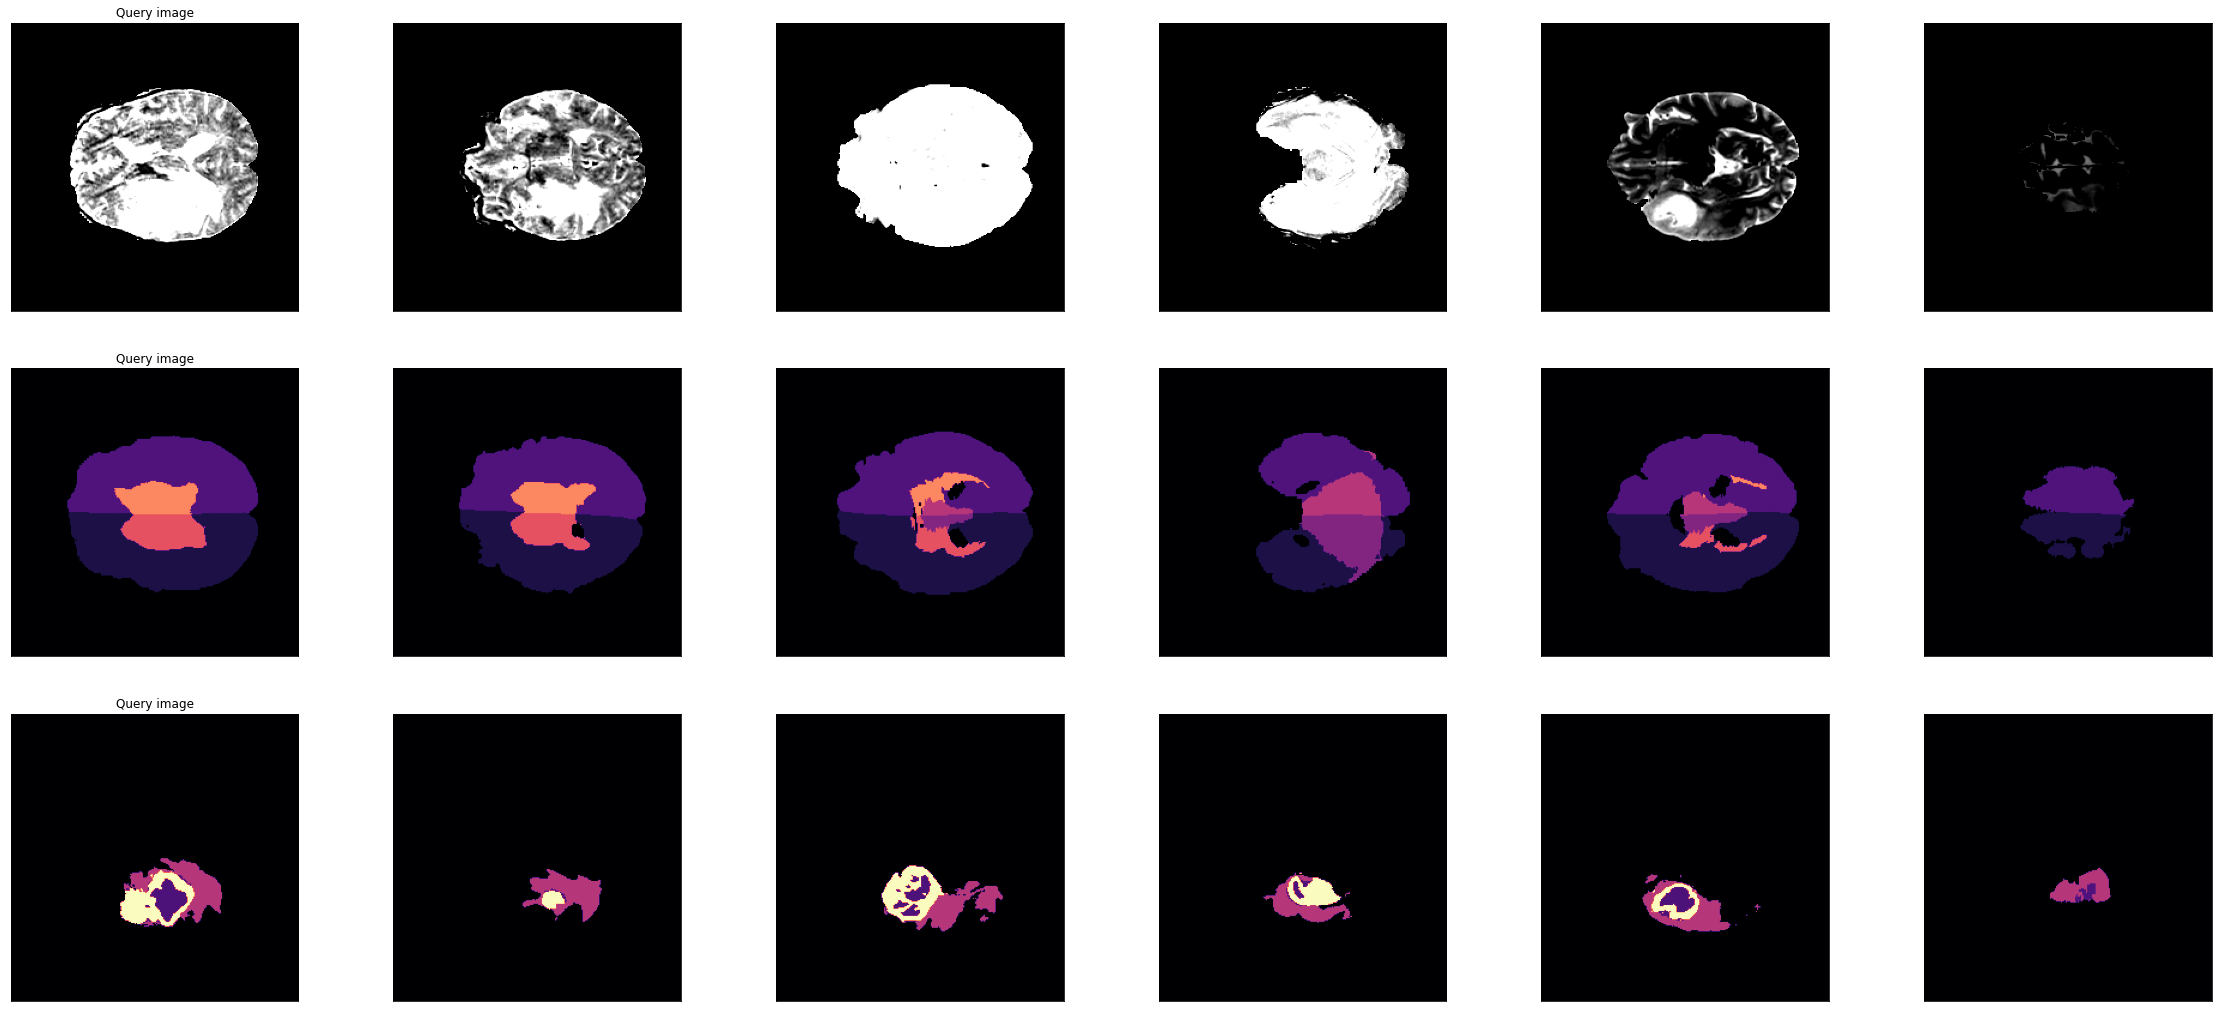

In [9]:
cbir.recom_system(lat_rep, img_idx=50, n_neighbors=5)